# Advanced Retrieval with LangChain

In the following notebook, we'll explore various methods of advanced retrieval using LangChain!

We'll touch on:

- Naive Retrieval
- Best-Matching 25 (BM25)
- Multi-Query Retrieval
- Parent-Document Retrieval
- Contextual Compression (a.k.a. Rerank)
- Ensemble Retrieval
- Semantic chunking

We'll also discuss how these methods impact performance on our set of documents with a simple RAG chain.

There will be two breakout rooms:

- 🤝 Breakout Room Part #1
  - Task 1: Getting Dependencies!
  - Task 2: Data Collection and Preparation
  - Task 3: Setting Up QDrant!
  - Task 4-10: Retrieval Strategies
- 🤝 Breakout Room Part #2
  - Activity: Evaluate with Ragas

# 🤝 Breakout Room Part #1

## Task 1: Getting Dependencies!

We're going to need a few specific LangChain community packages, like OpenAI (for our [LLM](https://platform.openai.com/docs/models) and [Embedding Model](https://platform.openai.com/docs/guides/embeddings)) and Cohere (for our [Reranker](https://cohere.com/rerank)).

> You do not need to run the following cells if you are running this notebook locally. 

In [1]:
#!pip install -qU langchain langchain-openai langchain-cohere rank_bm25

We're also going to be leveraging [Qdrant's](https://qdrant.tech/documentation/frameworks/langchain/) (pronounced "Quadrant") VectorDB in "memory" mode (so we can leverage it locally in our colab environment).

In [2]:
#!pip install -qU qdrant-client

We'll also provide our OpenAI key, as well as our Cohere API key.

In [3]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("Enter your OpenAI API Key:")

In [4]:
os.environ["COHERE_API_KEY"] = getpass.getpass("Cohere API Key:")

(For Activity #1) Setup for LangChain tracing.

In [5]:
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("Enter your LangChain API key: ")

os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "RAGAS-Eval-Session-13"

## Task 2: Data Collection and Preparation

We'll be using some reviews from the 4 movies in the John Wick franchise today to explore the different retrieval strategies.

These were obtained from IMDB, and are available in the [AIM Data Repository](https://github.com/AI-Maker-Space/DataRepository).

### Data Collection

We can simply `wget` these from GitHub.

You could use any review data you wanted in this step - just be careful to make sure your metadata is aligned with your choice.

In [6]:
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv -O john_wick_1.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv -O john_wick_2.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw3.csv -O john_wick_3.csv
!wget https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw4.csv -O john_wick_4.csv

--2025-05-18 15:50:04--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw1.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8002::154, 2606:50c0:8001::154, 2606:50c0:8003::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8002::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19628 (19K) [text/plain]
Saving to: ‘john_wick_1.csv’

john_wick_1.csv     100%[===================>]  19.17K  --.-KB/s    in 0s      

2025-05-18 15:50:05 (45.3 MB/s) - ‘john_wick_1.csv’ saved [19628/19628]

--2025-05-18 15:50:06--  https://raw.githubusercontent.com/AI-Maker-Space/DataRepository/main/jw2.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8001::154, 2606:50c0:8003::154, 2606:50c0:8000::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8001::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Len

### Data Preparation

We want to make sure all our documents have the relevant metadata for the various retrieval strategies we're going to be applying today.

- Self-Query: Wants as much metadata as we can provide
- Time-weighted: Wants temporal data

> NOTE: While we're creating a temporal relationship based on when these movies came out for illustrative purposes, it needs to be clear that the "time-weighting" in the Time-weighted Retriever is based on when the document was *accessed* last - not when it was created.

In [7]:
from langchain_community.document_loaders.csv_loader import CSVLoader
from datetime import datetime, timedelta

documents = []

for i in range(1, 5):
  loader = CSVLoader(
      file_path=f"john_wick_{i}.csv",
      metadata_columns=["Review_Date", "Review_Title", "Review_Url", "Author", "Rating"]
  )

  movie_docs = loader.load()
  for doc in movie_docs:

    # Add the "Movie Title" (John Wick 1, 2, ...)
    doc.metadata["Movie_Title"] = f"John Wick {i}"

    # convert "Rating" to an `int`, if no rating is provided - assume 0 rating
    doc.metadata["Rating"] = int(doc.metadata["Rating"]) if doc.metadata["Rating"] else 0

    # newer movies have a more recent "last_accessed_at"
    doc.metadata["last_accessed_at"] = datetime.now() - timedelta(days=4-i)

  documents.extend(movie_docs)

In [8]:
len(documents)



100

In [9]:
chunkSizes = []
for doc in documents:
    chunkSizes.append(len(doc.page_content))


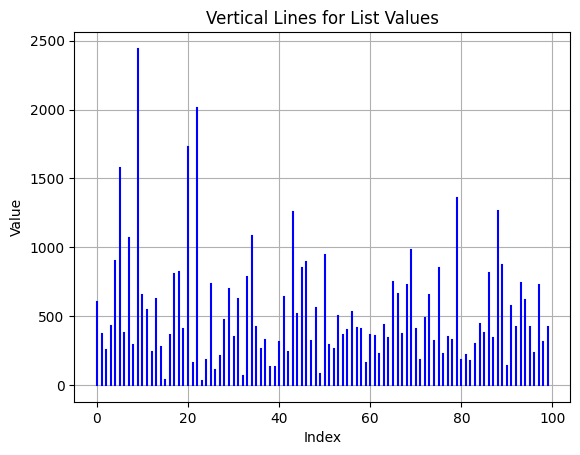

In [10]:
import matplotlib.pyplot as plt

# Example list of integers
data = chunkSizes

# Create x-axis values (indices of the list)
x = range(len(data))

# Plot vertical lines for each integer
for i, value in enumerate(data):
    plt.plot([i, i], [0, value], 'b-')  # 'b-' means blue line

# Customize the plot
plt.xlabel('Index')
plt.ylabel('Value')
plt.title('Vertical Lines for List Values')
plt.grid(True)

# Show the plot
plt.show()

Let's look at an example document to see if everything worked as expected!

In [11]:
documents[0]

Document(metadata={'source': 'john_wick_1.csv', 'row': 0, 'Review_Date': '6 May 2015', 'Review_Title': ' Kinetic, concise, and stylish; John Wick kicks ass.\n', 'Review_Url': '/review/rw3233896/?ref_=tt_urv', 'Author': 'lnvicta', 'Rating': 8, 'Movie_Title': 'John Wick 1', 'last_accessed_at': datetime.datetime(2025, 5, 15, 15, 50, 9, 139670)}, page_content=": 0\nReview: The best way I can describe John Wick is to picture Taken but instead of Liam Neeson it's Keanu Reeves and instead of his daughter it's his dog. That's essentially the plot of the movie. John Wick (Reeves) is out to seek revenge on the people who took something he loved from him. It's a beautifully simple premise for an action movie - when action movies get convoluted, they get bad i.e. A Good Day to Die Hard. John Wick gives the viewers what they want: Awesome action, stylish stunts, kinetic chaos, and a relatable hero to tie it all together. John Wick succeeds in its simplicity.")

## Task 3: Setting up QDrant!

Now that we have our documents, let's create a QDrant VectorStore with the collection name "JohnWick".

We'll leverage OpenAI's [`text-embedding-3-small`](https://openai.com/blog/new-embedding-models-and-api-updates) because it's a very powerful (and low-cost) embedding model.

> NOTE: We'll be creating additional vectorstores where necessary, but this pattern is still extremely useful.

In [12]:
from langchain_community.vectorstores import Qdrant
from langchain_openai import OpenAIEmbeddings

embeddings = OpenAIEmbeddings(model="text-embedding-3-small")

vectorstore = Qdrant.from_documents(
    documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWick"
)

## Task 4: Naive RAG Chain

Since we're focusing on the "R" in RAG today - we'll create our Retriever first.

### R - Retrieval

This naive retriever will simply look at each review as a document, and use cosine-similarity to fetch the 10 most relevant documents.

> NOTE: We're choosing `10` as our `k` here to provide enough documents for our reranking process later

In [13]:
naive_retriever = vectorstore.as_retriever(search_kwargs={"k" : 10})

### A - Augmented

We're going to go with a standard prompt for our simple RAG chain today! Nothing fancy here, we want this to mostly be about the Retrieval process.

In [14]:
from langchain_core.prompts import ChatPromptTemplate

RAG_TEMPLATE = """\
You are a helpful and kind assistant. Use the context provided below to answer the question.

If you do not know the answer, or are unsure, say you don't know.

Query:
{question}

Context:
{context}
"""

rag_prompt = ChatPromptTemplate.from_template(RAG_TEMPLATE)

### G - Generation

We're going to leverage `gpt-4.1-nano` as our LLM today, as - again - we want this to largely be about the Retrieval process.

In [70]:
# NOTE: I refactored this method to facilitate the tracing proocess
#       for the RAGAS evaluations later.

from langchain.chat_models import ChatOpenAI
from langchain.callbacks.tracers.langchain import LangChainTracer
from langchain.callbacks.manager import CallbackManager

def make_chat_model(retriever_name: str = None, model_name: str = "gpt-4o") -> ChatOpenAI:
    if retriever_name:
        tracer = LangChainTracer(
            project_name=f"ragas-eval-{retriever_name}",
            tags=[retriever_name, "retriever", "session-13", model_name]
        )
        callback_manager = CallbackManager([tracer])
        return ChatOpenAI(
            model=model_name,
            temperature=0,
            max_tokens=8192,
            callback_manager=callback_manager
        )
    else:
        return ChatOpenAI(
            model=model_name,
            temperature=0,
            max_tokens=1024
        )




### LCEL RAG Chain

We're going to use LCEL to construct our chain.

> NOTE: This chain will be exactly the same across the various examples with the exception of our Retriever!

In [16]:
from langchain_core.runnables import RunnablePassthrough
from operator import itemgetter
from langchain_core.output_parsers import StrOutputParser

chat_model = make_chat_model()

naive_retrieval_chain = (
    # INVOKE CHAIN WITH: {"question" : "<<SOME USER QUESTION>>"}
    # "question" : populated by getting the value of the "question" key
    # "context"  : populated by getting the value of the "question" key and chaining it into the base_retriever
    {"context": itemgetter("question") | naive_retriever, "question": itemgetter("question")}
    # "context"  : is assigned to a RunnablePassthrough object (will not be called or considered in the next step)
    #              by getting the value of the "context" key from the previous step
    | RunnablePassthrough.assign(context=itemgetter("context"))
    # "response" : the "context" and "question" values are used to format our prompt object and then piped
    #              into the LLM and stored in a key called "response"
    # "context"  : populated by getting the value of the "context" key from the previous step
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

/var/folders/5p/gq47dsys3k5663k1r5z8s3c40000gn/T/ipykernel_77341/3725807027.py:22: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  return ChatOpenAI(


Let's see how this simple chain does on a few different prompts.

> NOTE: You might think that we've cherry picked prompts that showcase the individual skill of each of the retrieval strategies - you'd be correct!

In [17]:
naive_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the context provided, it seems that people generally liked "John Wick." The reviews for the first film are mostly positive, highlighting its action sequences, Keanu Reeves\' performance, and the film\'s stylish and unique approach to the action genre. While there are a few mixed opinions, the overall sentiment is favorable, with many reviewers recommending the film to action fans and praising its entertainment value.'

In [18]:
naive_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review:\n\n- [John Wick 3 Review by ymyuseda](https://www.imdb.com/review/rw4854296/?ref_=tt_urv)'

In [19]:
naive_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the movie "John Wick," the main character, John Wick, is a retired hitman who is drawn back into the criminal underworld after a group of gangsters kill his dog and steal his car. The dog was a final gift from his recently deceased wife, and its death pushes him to seek revenge. The gangsters, led by a young Russian-American, are unaware of Wick\'s lethal skills and his past as a legendary assassin. As Wick seeks vengeance, he becomes the target of numerous hitmen, leading to a series of intense and violent confrontations. The film is known for its stylish action sequences and the portrayal of a criminal underworld where Wick is both feared and respected.'

Overall, this is not bad! Let's see if we can make it better!

## Task 5: Best-Matching 25 (BM25) Retriever

Taking a step back in time - [BM25](https://www.nowpublishers.com/article/Details/INR-019) is based on [Bag-Of-Words](https://en.wikipedia.org/wiki/Bag-of-words_model) which is a sparse representation of text.

In essence, it's a way to compare how similar two pieces of text are based on the words they both contain.

This retriever is very straightforward to set-up! Let's see it happen down below!


In [20]:
from langchain_community.retrievers import BM25Retriever

bm25_retriever = BM25Retriever.from_documents(documents)

We'll construct the same chain - only changing the retriever.

In [21]:
bm25_retrieval_chain = (
    {"context": itemgetter("question") | bm25_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at the responses!

In [22]:
bm25_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the context provided, opinions on the John Wick series appear to be mixed. Some reviews are very positive, praising the action sequences, style, and simplicity of the plot, particularly for the first movie. For example, one review describes "John Wick 1" as a "smoothest action film" and highly recommends it for action fans. Another review appreciates its "kinetic, concise, and stylish" nature.\n\nHowever, there are also negative reviews, particularly for the later movies in the series. For instance, "John Wick 3" is criticized for being "boring, dull, and full of stereotypes," and "John Wick 4" is described as "almost three hours of nothing" with a weak narrative.\n\nOverall, while some people seem to enjoy the John Wick movies, especially the first one, others find the later installments lacking in plot and overly reliant on action.'

In [23]:
bm25_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Based on the provided context, there are no reviews with a rating of 10.'

In [24]:
bm25_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'I don\'t know the specific plot details of "John Wick" based on the provided context. The context includes reviews of the John Wick series, but it does not provide a summary or specific events from the first movie.'

It's not clear that this is better or worse - but the `I don't know` isn't great!

## Task 6: Contextual Compression (Using Reranking)

Contextual Compression is a fairly straightforward idea: We want to "compress" our retrieved context into just the most useful bits.

There are a few ways we can achieve this - but we're going to look at a specific example called reranking.

The basic idea here is this:

- We retrieve lots of documents that are very likely related to our query vector
- We "compress" those documents into a smaller set of *more* related documents using a reranking algorithm.

We'll be leveraging Cohere's Rerank model for our reranker today!

All we need to do is the following:

- Create a basic retriever
- Create a compressor (reranker, in this case)

That's it!

Let's see it in the code below!

In [25]:
from langchain.retrievers.contextual_compression import ContextualCompressionRetriever
from langchain_cohere import CohereRerank

compressor = CohereRerank(model="rerank-english-v3.0")
compression_retriever = ContextualCompressionRetriever(
    base_compressor=compressor, base_retriever=naive_retriever
)

Let's create our chain again, and see how this does!

In [26]:
contextual_compression_retrieval_chain = (
    {"context": itemgetter("question") | compression_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [27]:
contextual_compression_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the context provided, it seems that people generally liked the first "John Wick" film. The reviews highlight its unique and stylish approach to action, the performance of Keanu Reeves, and the film\'s ability to entertain with its intense and well-choreographed action sequences. The reviewers recommend it highly, especially for action fans, and describe it as a standout film in the genre.'

In [28]:
contextual_compression_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL to that review is: /review/rw4854296/?ref_=tt_urv.'

In [29]:
contextual_compression_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the movie "John Wick," the main character, John Wick, is an ex-hitman who comes out of retirement to seek revenge on the gangsters who killed his dog and stole his car. The dog was a final gift from his recently deceased wife, making the loss deeply personal. As he pursues vengeance, Wick becomes the target of numerous hitmen due to his lethal reputation and the price on his head. The film is known for its intense action sequences, stylish stunts, and the portrayal of Wick as a relentless and skilled assassin.'

We'll need to rely on something like Ragas to help us get a better sense of how this is performing overall - but it "feels" better!

## Task 7: Multi-Query Retriever

Typically in RAG we have a single query - the one provided by the user.

What if we had....more than one query!

In essence, a Multi-Query Retriever works by:

1. Taking the original user query and creating `n` number of new user queries using an LLM.
2. Retrieving documents for each query.
3. Using all unique retrieved documents as context

So, how is it to set-up? Not bad! Let's see it down below!



In [30]:
from langchain.retrievers.multi_query import MultiQueryRetriever

multi_query_retriever = MultiQueryRetriever.from_llm(
    retriever=naive_retriever, llm=chat_model
)

In [31]:
multi_query_retrieval_chain = (
    {"context": itemgetter("question") | multi_query_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

In [32]:
multi_query_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the context provided, it seems that the "John Wick" series is generally well-received by audiences. Many reviews highlight the films\' action sequences, style, and Keanu Reeves\' performance positively. The first film, in particular, is praised for its unique approach to the action genre and has been described as a surprise hit. However, there are some mixed reviews, especially for the later installments, with some viewers feeling that the series has become repetitive or lacks depth. Overall, the series appears to have a strong fan base and is generally liked, but not universally loved by everyone.'

In [33]:
multi_query_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL to that review is: [/review/rw4854296/?ref_=tt_urv](https://www.imdb.com/review/rw4854296/?ref_=tt_urv).'

In [34]:
multi_query_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the movie "John Wick," the plot revolves around the character John Wick, played by Keanu Reeves, who is a retired hitman. The story begins with John grieving the loss of his wife. After her death, he receives a puppy as a final gift from her to help him cope with his grief. However, his life takes a violent turn when a group of thugs, led by a young Russian-American, break into his home, steal his car, and kill his dog. This act of violence pulls John Wick out of retirement as he seeks revenge against those who wronged him. The film is known for its stylish action sequences, with John Wick waging a one-man war against the Russian Mafia, showcasing his skills as a legendary assassin. The movie is praised for its simplicity, intense action, and Keanu Reeves\' performance.'

## Task 8: Parent Document Retriever

A "small-to-big" strategy - the Parent Document Retriever works based on a simple strategy:

1. Each un-split "document" will be designated as a "parent document" (You could use larger chunks of document as well, but our data format allows us to consider the overall document as the parent chunk)
2. Store those "parent documents" in a memory store (not a VectorStore)
3. We will chunk each of those documents into smaller documents, and associate them with their respective parents, and store those in a VectorStore. We'll call those "child chunks".
4. When we query our Retriever, we will do a similarity search comparing our query vector to the "child chunks".
5. Instead of returning the "child chunks", we'll return their associated "parent chunks".

Okay, maybe that was a few steps - but the basic idea is this:

- Search for small documents
- Return big documents

The intuition is that we're likely to find the most relevant information by limiting the amount of semantic information that is encoded in each embedding vector - but we're likely to miss relevant surrounding context if we only use that information.

Let's start by creating our "parent documents" and defining a `RecursiveCharacterTextSplitter`.

In [35]:
from langchain.retrievers import ParentDocumentRetriever
from langchain.storage import InMemoryStore
from langchain_text_splitters import RecursiveCharacterTextSplitter
from qdrant_client import QdrantClient, models

parent_docs = documents
child_splitter = RecursiveCharacterTextSplitter(chunk_size=200)

We'll need to set up a new QDrant vectorstore - and we'll use another useful pattern to do so!

> NOTE: We are manually defining our embedding dimension, you'll need to change this if you're using a different embedding model.

In [36]:
client = QdrantClient(location=":memory:")

client.create_collection(
    collection_name="full_documents",
    vectors_config=models.VectorParams(size=1536, distance=models.Distance.COSINE)
)

parent_document_vectorstore = Qdrant(
    collection_name="full_documents", embeddings=OpenAIEmbeddings(model="text-embedding-3-small"), client=client
)

/var/folders/5p/gq47dsys3k5663k1r5z8s3c40000gn/T/ipykernel_77341/3574430551.py:8: LangChainDeprecationWarning: The class `Qdrant` was deprecated in LangChain 0.0.37 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-qdrant package and should be used instead. To use it run `pip install -U :class:`~langchain-qdrant` and import as `from :class:`~langchain_qdrant import Qdrant``.
  parent_document_vectorstore = Qdrant(


Now we can create our `InMemoryStore` that will hold our "parent documents" - and build our retriever!

In [37]:
store = InMemoryStore()

parent_document_retriever = ParentDocumentRetriever(
    vectorstore = parent_document_vectorstore,
    docstore=store,
    child_splitter=child_splitter,
)

By default, this is empty as we haven't added any documents - let's add some now!

In [38]:
parent_document_retriever.add_documents(parent_docs, ids=None)

We'll create the same chain we did before - but substitute our new `parent_document_retriever`.

In [39]:
parent_document_retrieval_chain = (
    {"context": itemgetter("question") | parent_document_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's give it a whirl!

In [40]:
parent_document_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the context provided, it seems that opinions on the John Wick series are mixed. Some people, like the author of the second document, find the series to be consistently well-received and even consider "John Wick: Chapter 4" to be the best of the series. On the other hand, the author of the first document had a very negative opinion of "John Wick 4," describing it as "horrible" and criticizing various aspects of the film. The third document shows a positive review of the first John Wick movie, highlighting its action and emotional setup. Overall, while there are some negative opinions, there are also strong positive reviews, suggesting that many people do generally like the John Wick series.'

In [41]:
parent_document_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL to that review is: /review/rw4854296/?ref_=tt_urv.'

In [42]:
parent_document_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the first "John Wick" movie, John Wick, played by Keanu Reeves, is a retired hitman who comes out of retirement to seek vengeance after gangsters kill his dog and steal his car. The dog was a final gift from his recently deceased wife, and its death pushes him to track down those responsible. As he seeks revenge, he becomes the target of numerous hitmen due to a bounty placed on his head.\n\nIn "John Wick: Chapter 2," the story continues with John Wick being forced back into the world of assassins to repay an old debt. The movie begins with him retrieving his stolen car, and he is soon drawn into a conflict involving the Assassin\'s Guild. The sequel involves a lot of action, with John Wick traveling to various locations and facing off against numerous assassins.'

Overall, the performance *seems* largely the same. We can leverage a tool like [Ragas]() to more effectively answer the question about the performance.

## Task 9: Ensemble Retriever

In brief, an Ensemble Retriever simply takes 2, or more, retrievers and combines their retrieved documents based on a rank-fusion algorithm.

In this case - we're using the [Reciprocal Rank Fusion](https://plg.uwaterloo.ca/~gvcormac/cormacksigir09-rrf.pdf) algorithm.

Setting it up is as easy as providing a list of our desired retrievers - and the weights for each retriever.

In [43]:
from langchain.retrievers import EnsembleRetriever

retriever_list = [bm25_retriever, naive_retriever, parent_document_retriever, compression_retriever, multi_query_retriever]
equal_weighting = [1/len(retriever_list)] * len(retriever_list)

ensemble_retriever = EnsembleRetriever(
    retrievers=retriever_list, weights=equal_weighting
)

We'll pack *all* of these retrievers together in an ensemble.

In [44]:
ensemble_retrieval_chain = (
    {"context": itemgetter("question") | ensemble_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

Let's look at our results!

In [45]:
ensemble_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the context provided, it seems that people generally liked "John Wick." The reviews for the first film are mostly positive, with high ratings and praise for its action sequences, style, and Keanu Reeves\' performance. There are some mixed reviews, but the overall sentiment appears to be favorable. Additionally, the series as a whole is noted for being consistent and well-received, with the fourth installment also receiving positive feedback despite some criticism.'

In [46]:
ensemble_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. The URL to that review is: [/review/rw4854296/?ref_=tt_urv](https://www.imdb.com/review/rw4854296/?ref_=tt_urv).'

In [47]:
ensemble_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the movie "John Wick," the main character, John Wick, is a retired hitman who is drawn back into the criminal underworld after a group of Russian mobsters kill his dog and steal his car. The dog was a final gift from his recently deceased wife, and its death leaves him with nothing to lose. Fueled by a desire for revenge, Wick embarks on a violent rampage against those who wronged him. The film is known for its intense action sequences, stylish choreography, and the portrayal of a criminal underworld where Wick is both feared and respected.'

## Task 10: Semantic Chunking

While this is not a retrieval method - it *is* an effective way of increasing retrieval performance on corpora that have clean semantic breaks in them.

Essentially, Semantic Chunking is implemented by:

1. Embedding all sentences in the corpus.
2. Combining or splitting sequences of sentences based on their semantic similarity based on a number of [possible thresholding methods](https://python.langchain.com/docs/how_to/semantic-chunker/):
  - `percentile`
  - `standard_deviation`
  - `interquartile`
  - `gradient`
3. Each sequence of related sentences is kept as a document!

Let's see how to implement this!

> NOTE: You do not need to run this cell if you're running this locally

In [48]:
#!pip install -qU langchain_experimental

We'll use the `percentile` thresholding method for this example which will:

Calculate all distances between sentences, and then break apart sequences of setences that exceed a given percentile among all distances.

In [49]:
from langchain_experimental.text_splitter import SemanticChunker

semantic_chunker = SemanticChunker(
    embeddings,
    breakpoint_threshold_type="percentile"
)

Now we can split our documents.

In [50]:
semantic_documents = semantic_chunker.split_documents(documents)

Let's create a new vector store.

In [51]:
semantic_vectorstore = Qdrant.from_documents(
    semantic_documents,
    embeddings,
    location=":memory:",
    collection_name="JohnWickSemantic"
)

We'll use naive retrieval for this example.

In [52]:
semantic_retriever = semantic_vectorstore.as_retriever(search_kwargs={"k" : 10})

Finally we can create our classic chain!

In [53]:
semantic_retrieval_chain = (
    {"context": itemgetter("question") | semantic_retriever, "question": itemgetter("question")}
    | RunnablePassthrough.assign(context=itemgetter("context"))
    | {"response": rag_prompt | chat_model, "context": itemgetter("context")}
)

And view the results!

In [54]:
semantic_retrieval_chain.invoke({"question" : "Did people generally like John Wick?"})["response"].content

'Based on the context provided, it seems that people generally liked the John Wick series. The reviews for the first film are particularly positive, with high ratings and praise for its action sequences and style. While there are some mixed reviews for the third film, the overall sentiment across the series appears to be favorable, with the fourth installment also receiving positive feedback.'

In [55]:
semantic_retrieval_chain.invoke({"question" : "Do any reviews have a rating of 10? If so - can I have the URLs to those reviews?"})["response"].content

'Yes, there is a review with a rating of 10. Here is the URL to that review:\n\n- [Review by ymyuseda](https://www.imdb.com/review/rw4854296/?ref_=tt_urv)'

In [56]:
semantic_retrieval_chain.invoke({"question" : "What happened in John Wick?"})["response"].content

'In the movie "John Wick," the main character, John Wick, played by Keanu Reeves, is a retired assassin who comes out of retirement to seek revenge on the people who wronged him. The story begins with the death of his beloved wife, and shortly after, a group of thugs led by the son of a Russian gangster break into his house, steal his car, and kill his dog, which was a final gift from his wife. This act of violence prompts John Wick to unleash his skills as a legendary hitman to track down and take revenge on those responsible. The film is known for its intense action sequences, stylish stunts, and the portrayal of a criminal underworld.'

# 🤝 Breakout Room Part #2

#### 🏗️ Activity #1

Your task is to evaluate the various Retriever methods against eachother.

You are expected to:

1. Create a "golden dataset"
 - Use Synthetic Data Generation (powered by Ragas, or otherwise) to create this dataset
2. Evaluate each retriever with *retriever specific* Ragas metrics
 - Semantic Chunking is not considered a retriever method and will not be required for marks, but you may find it useful to do a "semantic chunking on" vs. "semantic chunking off" comparision between them
3. Compile these in a list and write a small paragraph about which is best for this particular data and why.

Your analysis should factor in:
  - Cost
  - Latency
  - Performance

> NOTE: This is **NOT** required to be completed in class. Please spend time in your breakout rooms creating a plan before moving on to writing code.

##### HINTS:

- LangSmith provides detailed information about latency and cost.

## Retriever Evaluation

### Generating the Golden Dataset
The following code will use RAGAS to generate 10 questions from the base knowledge (`documents`) loaded earlier in this notebook. 

In [57]:
from ragas.testset import TestsetGenerator

generator = TestsetGenerator.from_langchain(
    llm=make_chat_model(),
    embedding_model=embeddings
)

testset = generator.generate_with_langchain_docs(
    documents=documents,
    testset_size=12,
    with_debugging_logs=False
)

# Accept only samples with a valid ground truth. Some will not due to rate limit errors, so I also increased the testset size above.
valid_samples = [s for s in testset.samples if s.eval_sample.reference is not None]

# print the testset (Question and Grounded Truth)
for sample in testset.samples:
    print("Q:", sample.eval_sample.user_input)
    print("GT:", sample.eval_sample.reference)
    print("—" * 60)


Applying SummaryExtractor:   0%|          | 0/44 [00:00<?, ?it/s]

Applying CustomNodeFilter:   0%|          | 0/100 [00:00<?, ?it/s]

Node 65b13e5b-b0a8-4690-9db0-206697a29bce does not have a summary. Skipping filtering.
Node 2bcfecdc-8d55-457f-b945-bb6b4a2e1ea2 does not have a summary. Skipping filtering.
Node ef37caa7-f382-4e73-a777-6aff367fbb04 does not have a summary. Skipping filtering.
Node 68a4b753-5a5e-4d62-85c4-65b51840c752 does not have a summary. Skipping filtering.
Node faad2dfb-d1eb-4d41-8250-35bd6da361ff does not have a summary. Skipping filtering.
Node 76c8270e-cfa1-41c2-a022-2efeb137f882 does not have a summary. Skipping filtering.
Node 880822ec-dc79-4143-adfb-055612438496 does not have a summary. Skipping filtering.
Node ab9fcb7f-7554-4dab-a682-6717108182d7 does not have a summary. Skipping filtering.
Node ec284fb3-a865-4d44-bf7c-730ed0bd84f9 does not have a summary. Skipping filtering.
Node 299d5d24-071b-4037-aed9-a5679096431d does not have a summary. Skipping filtering.
Node dfa06cc8-6cf7-415e-9766-097496bca4d8 does not have a summary. Skipping filtering.
Node 5c52f1a4-128d-43de-948c-29011c54f526 d

Applying [EmbeddingExtractor, ThemesExtractor, NERExtractor]:   0%|          | 0/244 [00:00<?, ?it/s]

unable to apply transformation: Error code: 429 - {'error': {'message': 'Rate limit reached for gpt-4o in organization org-R7FhOpnBh8AV6HY4M573NtwE on tokens per min (TPM): Limit 30000, Used 29960, Requested 585. Please try again in 1.09s. Visit https://platform.openai.com/account/rate-limits to learn more.', 'type': 'tokens', 'param': None, 'code': 'rate_limit_exceeded'}}


Applying [CosineSimilarityBuilder, OverlapScoreBuilder]:   0%|          | 0/2 [00:00<?, ?it/s]

Generating personas:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Scenarios:   0%|          | 0/3 [00:00<?, ?it/s]

Generating Samples:   0%|          | 0/12 [00:00<?, ?it/s]

Q: How does the plot of John Wick compare to Liam Neeson's role in Taken?
GT: The plot of John Wick can be described as similar to Taken, but instead of Liam Neeson, it features Keanu Reeves, and instead of his daughter, it's his dog. Both films involve the protagonist seeking revenge for something they loved being taken from them.
————————————————————————————————————————————————————————————
Q: What has been the reception of the 'John Wick' film series, particularly with the release of its fourth installment?
GT: The 'John Wick' film series has been immensely successful, with the fourth installment scoring highly at the cinemas. The previous three films are apparently loved by audiences worldwide.
————————————————————————————————————————————————————————————
Q: Wut makes Keanu's performnce in John Wick so special, even tho the story is simpl?
GT: Keanu's performance in John Wick is special because the film, directed by Chad Stahelski, features real virtuoso action sequences and well-mad

Save the test questions for potential reuse.

In [58]:
import json

with open("testset.json", "w") as f:
    json.dump([s.model_dump() for s in testset.samples], f, indent=2)


### Generate answers and metrics using each of the seven retrievers

Create this `safe_generate(...)` function to avoid rate and token limit issues.


In [66]:
import time

def safe_generate(llm, question, retries=3, delay=2):
    for attempt in range(retries):
        try:
            result = llm.invoke(question)
            return result.content if hasattr(result, "content") else str(result)
        except Exception as e:
            print(f"⚠️ Retry {attempt+1} for generation failed: {e}")
            time.sleep(delay)
    return "Generation failed"

Create the common method for generating and evaluating answers to each question.

In [63]:
from datasets import Dataset
from ragas import evaluate
from ragas.metrics import (
    answer_relevancy,
    faithfulness,
    context_recall,
    context_precision,
    answer_correctness,
)


def evaluate_per_sample(samples, retriever, llm, embeddings, name="naive", sleep=3):
    scores = {
        "answer_correctness": [],
        "answer_relevancy": [],
        "faithfulness": [],
        "context_recall": [],
        "context_precision": [],
    }

    for i, sample in enumerate(samples, 1):
        question = sample.eval_sample.user_input
        ground_truth = sample.eval_sample.reference

        docs = retriever.get_relevant_documents(question)
        contexts = [doc.page_content for doc in docs]
        
        # Use safe LLM generation
        answer = safe_generate(llm, question)
        
        eval_ds = Dataset.from_dict({
            "question": [question],
            "contexts": [contexts],
            "answer": [answer],
            "ground_truth": [ground_truth],
        })

        try:
            result = evaluate(
                dataset=eval_ds,
                metrics=[
                    answer_relevancy,
                    faithfulness,
                    context_recall,
                    context_precision,
                    answer_correctness,
                ],
                llm=llm,
                embeddings=embeddings
            )
            for k in scores:
                scores[k].append(result[k])
            print(f"[{name}] ✅ {i}/{len(samples)} complete")
        except Exception as e:
            print(f"[{name}] ❌ {i}/{len(samples)} failed: {e}")
            for k in scores:
                scores[k].append(None)

        time.sleep(sleep)  # ⏱️ Control rate limit manually

    return scores


#### Summarize the scores after each run

In [60]:
import numpy as np
import pandas as pd

def summarize_scores(scores_dict, name="Naive"):
    summary = {k: round(np.nanmean([v for v in values if v is not None]), 4)
               for k, values in scores_dict.items()}
    return pd.DataFrame([summary], index=[name])


#### Run answer generation for every retriever

In [64]:
# Create a collection of the seven retriever types.
retrievers = {
    "naive": naive_retriever,
    "bm25": bm25_retriever,
    "compression": compression_retriever,
    "multi_query": multi_query_retriever,
    "parent": parent_document_retriever,
    "ensemble": ensemble_retriever,
    "semantic": semantic_retriever,
}


In [73]:
all_scores = {}
all_dataframes = []

for retriever_name, retriever in retrievers.items():
    print(f"\n🔍 Evaluating retriever: {retriever_name}")

    scores = evaluate_per_sample(
        samples=valid_samples,
        retriever=retriever,
        llm=make_chat_model(retriever_name=retriever_name, model_name="gpt-4o"),
        embeddings=embeddings,
        name=retriever_name,
        sleep=4
    )

    # Store scores and summarized DataFrame
    all_scores[retriever_name] = scores
    df = summarize_scores(scores, name=retriever_name.capitalize())
    all_dataframes.append(df)


🔍 Evaluating retriever: naive


/var/folders/5p/gq47dsys3k5663k1r5z8s3c40000gn/T/ipykernel_77341/1841367254.py:15: DeprecationWarning: callback_manager is deprecated. Please use callbacks instead.
  return ChatOpenAI(


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 1/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 2/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 3/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 4/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 5/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 6/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 7/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 8/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 9/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 10/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 11/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[naive] ✅ 12/12 complete

🔍 Evaluating retriever: bm25


/var/folders/5p/gq47dsys3k5663k1r5z8s3c40000gn/T/ipykernel_77341/1841367254.py:15: DeprecationWarning: callback_manager is deprecated. Please use callbacks instead.
  return ChatOpenAI(


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 1/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 2/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 3/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 4/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 5/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 6/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 7/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 8/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 9/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 10/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 11/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[bm25] ✅ 12/12 complete

🔍 Evaluating retriever: compression


/var/folders/5p/gq47dsys3k5663k1r5z8s3c40000gn/T/ipykernel_77341/1841367254.py:15: DeprecationWarning: callback_manager is deprecated. Please use callbacks instead.
  return ChatOpenAI(


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 1/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 2/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 3/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 4/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 5/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 6/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 7/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 8/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 9/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 10/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 11/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[compression] ✅ 12/12 complete

🔍 Evaluating retriever: multi_query


/var/folders/5p/gq47dsys3k5663k1r5z8s3c40000gn/T/ipykernel_77341/1841367254.py:15: DeprecationWarning: callback_manager is deprecated. Please use callbacks instead.
  return ChatOpenAI(


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 1/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 2/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 3/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 4/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 5/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 6/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 7/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 8/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 9/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 10/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 11/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[multi_query] ✅ 12/12 complete

🔍 Evaluating retriever: parent


/var/folders/5p/gq47dsys3k5663k1r5z8s3c40000gn/T/ipykernel_77341/1841367254.py:15: DeprecationWarning: callback_manager is deprecated. Please use callbacks instead.
  return ChatOpenAI(


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 1/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 2/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 3/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 4/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 5/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 6/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 7/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 8/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 9/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 10/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 11/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[parent] ✅ 12/12 complete

🔍 Evaluating retriever: ensemble


/var/folders/5p/gq47dsys3k5663k1r5z8s3c40000gn/T/ipykernel_77341/1841367254.py:15: DeprecationWarning: callback_manager is deprecated. Please use callbacks instead.
  return ChatOpenAI(


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 1/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 2/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 3/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 4/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 5/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 6/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 7/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 8/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 9/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 10/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 11/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[ensemble] ✅ 12/12 complete

🔍 Evaluating retriever: semantic


/var/folders/5p/gq47dsys3k5663k1r5z8s3c40000gn/T/ipykernel_77341/1841367254.py:15: DeprecationWarning: callback_manager is deprecated. Please use callbacks instead.
  return ChatOpenAI(


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 1/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 2/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 3/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 4/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 5/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 6/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 7/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 8/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 9/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 10/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 11/12 complete


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

[semantic] ✅ 12/12 complete


#### Combine the dataframes.

In [86]:
# Combine all dataframes into a single dataframe

final_df = pd.concat(all_dataframes, axis=0)

print(final_df)



             answer_correctness  answer_relevancy  faithfulness  \
Naive                    0.3735            0.7773        0.4972   
Bm25                     0.3926            0.7761        0.3187   
Compression              0.4080            0.7761        0.3448   
Multi_query              0.3848            0.7734        0.4938   
Parent                   0.3646            0.7760        0.2813   
Ensemble                 0.3335            0.7734        0.6159   
Semantic                 0.3465            0.7771        0.4461   

             context_recall  context_precision  
Naive                0.8819             0.8706  
Bm25                 0.7778             0.7222  
Compression          0.8819             1.0000  
Multi_query          0.8264             0.7826  
Parent               0.5694             0.8056  
Ensemble             0.9236             0.7999  
Semantic             0.8542             0.6727  


#### Retrieve LangSmith metrics and append to the RAGAS metrics

In [106]:
from langsmith import Client

def get_langsmith_metrics(project_name, model_name="gpt-4o"):
    client = Client()
    runs = list(client.list_runs(project_name=project_name, run_type="llm"))

    latencies = []
    costs = []

    for run in runs:
        full_run = client.read_run(run.id)

        if full_run.start_time and full_run.end_time:
            duration = (full_run.end_time - full_run.start_time).total_seconds()
            latencies.append(duration)

        usage = (
            full_run.outputs
            .get("llm_output", {})
            .get("token_usage", {})
        )

        input_tokens = usage.get("prompt_tokens", 0)
        output_tokens = usage.get("completion_tokens", 0)

        if "gpt-4o" in model_name:
            cost = (input_tokens / 1000) * 0.005 + (output_tokens / 1000) * 0.015
        elif "gpt-3.5" in model_name:
            cost = (input_tokens / 1000) * 0.0015 + (output_tokens / 1000) * 0.002
        else:
            cost = 0

        costs.append(cost)

    avg_latency = round(sum(latencies) / len(latencies), 3) if latencies else None
    total_cost = round(sum(costs), 4) if costs else None

    return avg_latency, total_cost


In [111]:
latencies = []
costs = []

for name in retrievers.keys():
    project_name = f"ragas-eval-{name}"
    print("Processing tracing information for", project_name)
    latency, cost = get_langsmith_metrics(project_name)
    latencies.append(latency)
    costs.append(cost)

final_df["avg_latency_s"] = latencies
final_df["total_cost_usd"] = costs


Processing tracing information for ragas-eval-naive
Processing tracing information for ragas-eval-bm25
Processing tracing information for ragas-eval-compression
Processing tracing information for ragas-eval-multi_query
Processing tracing information for ragas-eval-parent
Processing tracing information for ragas-eval-ensemble
Processing tracing information for ragas-eval-semantic


In [112]:
print("Latency Values: ", latencies)
print("Cost Values: ", costs)

print(final_df)

Latency Values:  [6.424, 6.254, 6.875, 6.461, 6.401, 6.437, 6.452]
Cost Values:  [0.2385, 0.1605, 0.146, 0.147, 0.1475, 0.1479, 0.1478]
             answer_correctness  answer_relevancy  faithfulness  \
Naive                    0.3735            0.7773        0.4972   
Bm25                     0.3926            0.7761        0.3187   
Compression              0.4080            0.7761        0.3448   
Multi_query              0.3848            0.7734        0.4938   
Parent                   0.3646            0.7760        0.2813   
Ensemble                 0.3335            0.7734        0.6159   
Semantic                 0.3465            0.7771        0.4461   

             context_recall  context_precision  avg_latency_s  total_cost_usd  
Naive                0.8819             0.8706          6.424          0.2385  
Bm25                 0.7778             0.7222          6.254          0.1605  
Compression          0.8819             1.0000          6.875          0.1460  
Multi_q

#### Prepare the final table output

In [113]:
from tabulate import tabulate

# switch the columns and the rows so that the metrics are the rows and the retrievers are the columns.
final_df = final_df.T

# Define groups
retriever_metrics = ["context_precision", "context_recall", "faithfulness"]
answer_metrics = ["answer_relevancy", "answer_correctness"]
infra_metrics = ["avg_latency_s", "total_cost_usd"]

# Reorder with blank rows as visual separators
ordered_rows = (
    retriever_metrics +
    answer_metrics +
    infra_metrics
)

# Reindex with visual grouping
df_grouped = final_df.reindex(ordered_rows)

# Add a "Group" column for display/printing
group_labels = {
    "context_precision": "Retriever",
    "context_recall": "Retriever",
    "faithfulness": "Retriever",
    "answer_relevancy": "Answer",
    "answer_correctness": "Answer",
    "avg_latency_s": "Infra",
    "total_cost_usd": "Infra",
}

df_grouped.insert(0, "Group", [group_labels.get(m, "") for m in df_grouped.index])


print(tabulate(df_grouped, headers="keys", tablefmt="grid"))


+--------------------+-----------+---------+--------+---------------+---------------+----------+------------+------------+
|                    | Group     |   Naive |   Bm25 |   Compression |   Multi_query |   Parent |   Ensemble |   Semantic |
+====================+===========+=========+========+===============+===============+==========+============+============+
| context_precision  | Retriever |  0.8706 | 0.7222 |        1      |        0.7826 |   0.8056 |     0.7999 |     0.6727 |
+--------------------+-----------+---------+--------+---------------+---------------+----------+------------+------------+
| context_recall     | Retriever |  0.8819 | 0.7778 |        0.8819 |        0.8264 |   0.5694 |     0.9236 |     0.8542 |
+--------------------+-----------+---------+--------+---------------+---------------+----------+------------+------------+
| faithfulness       | Retriever |  0.4972 | 0.3187 |        0.3448 |        0.4938 |   0.2813 |     0.6159 |     0.4461 |
+---------------

### Final RAGAS Evaluation Results ↕️

![RAGAS-Evaluation-Chart](assets/AIE6-S13-final_ragas_metrics_by_retriever.png)